In [3]:
# Jade Chongsathapornpong, June 2023
import fabio
import larch.io

import pyFAI
import pyFAI.calibrant
from pyFAI.gui.jupyter.calib import Calibration
# from pyFAI.test.utilstest import UtilsTest

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

#image = fabio.open(UtilsTest.getimage("Pilatus1M.edf")).data
f = larch.io.h5file('../Data/ROCK/XRD/lab6_250mm_000002.nxs', 'r')

%matplotlib nbagg

In [7]:
f.__dict__

{'_libver': (None, 'latest'), '_id': <h5py.h5f.FileID at 0x12c17e950e0>}

# Calibration

<IPython.core.display.Javascript object>


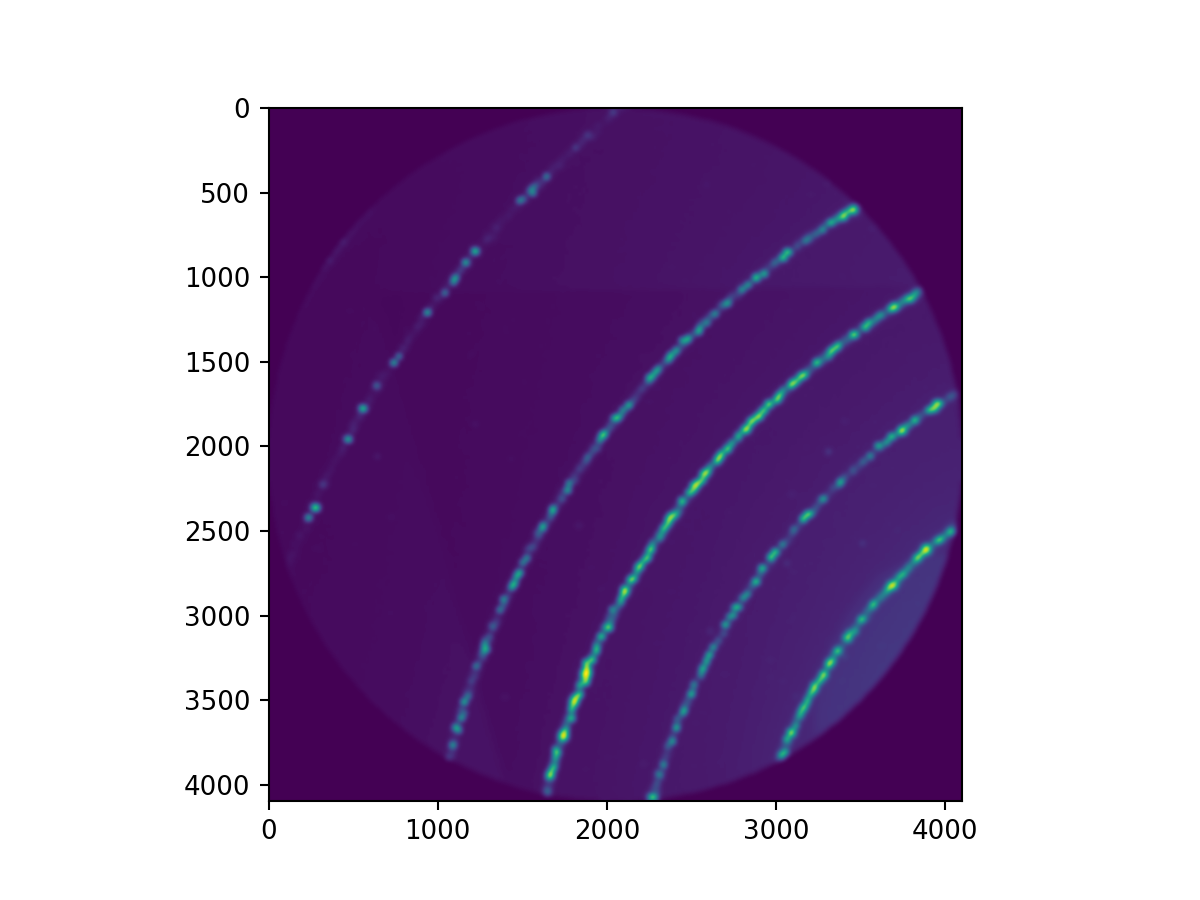

(4096, 4096)

In [6]:
smooth = True
bit_depth = 16
detector_px = (4096, 4096)
base_image = np.array(f.entry.scan_data.nxsignal).transpose((1,2,0))

if smooth:
    # Decimate bit depth to accommodate 8-bit filters
    image = base_image // (2 ** (bit_depth - 8))
    # Upscale to fit the pyFAI detector's size (since we used pixel binning)
    image = Image.fromarray(image.squeeze()).resize(detector_px) # 8-bit integer grayscale
    image = image.convert('L')
    # Filter
    image = image.filter(ImageFilter.MaxFilter(11))
    image = image.filter(ImageFilter.GaussianBlur(15))
else:
    # Use full bit depth of image
    image = Image.fromarray(base_image.squeeze()).resize(detector_px)

image = np.array(image)
plt.imshow(image)
image.shape

In [4]:
energy = 11000 # eV
hc = 1.23984198e-6 # eV m
l = hc / energy
print("Wavelength", l)

det = pyFAI.detector_factory("Rayonix SX165")
print(det)
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
print(LaB6)
LaB6.wavelength = l # m

Wavelength 1.1271290727272727e-10
Detector Rayonix SX165	 PixelSize= 3.950e-05, 3.950e-05 m
LaB6 Calibrant with 1441 reflections 


In [8]:
calib = Calibration(image, calibrant=LaB6, wavelength=l, detector=det)
# NOTE: For the version of matplotlib I have, it seems in pyFAI/gui/mpl_calib.py :: MplCalibWidget.contour() line 248,
# it seems self.ax.collections.clear() does not work. I replaced it with self.ax.clear(), but I doubt this is intended
# behavior. The calibration seems to work regardless, though.

# NOTE 2: Using the versions of these packages for Python 3.7 instead of 3.8+, this seems to work without modifying the code.

Before refinement, the geometry is:
Detector Rayonix SX165	 PixelSize= 3.950e-05, 3.950e-05 m
Wavelength= 1.127129e-10 m
SampleDetDist= 2.728602e-01 m	PONI= 2.052018e-02, 2.350404e-03 m	rot1=2.217505  rot2=2.600221  rot3=0.000000 rad
DirectBeamDist= 528.391 mm	Center: x=9208.691, y=7412.818 pix	Tilt= 58.909° tiltPlanRotation= 36.996° 𝛌= 1.127Å
Detector Rayonix SX165	 PixelSize= 3.950e-05, 3.950e-05 m
Wavelength= 1.127129e-10 m
SampleDetDist= 2.728585e-01 m	PONI= 2.052080e-02, 2.351392e-03 m	rot1=2.217505  rot2=2.600221  rot3=0.000000 rad
DirectBeamDist= 528.388 mm	Center: x=9208.658, y=7412.791 pix	Tilt= 58.909° tiltPlanRotation= 36.996° 𝛌= 1.127Å
Detector Rayonix SX165	 PixelSize= 3.950e-05, 3.950e-05 m
Wavelength= 1.127129e-10 m
SampleDetDist= 2.728585e-01 m	PONI= 2.052080e-02, 2.351392e-03 m	rot1=2.217505  rot2=2.600221  rot3=0.000000 rad
DirectBeamDist= 528.388 mm	Center: x=9208.658, y=7412.791 pix	Tilt= 58.909° tiltPlanRotation= 36.996° 𝛌= 1.127Å
Detector Rayonix SX165	 PixelSize=

# Integration

In [ ]:
### OPTIONAL ###
# Load Geometry Reference from PONI data file
# TODO


In [7]:
gr = calib.geoRef
print(gr)
print("Fixed", calib.fixed)
print("Loss", gr.chi2())

Detector Rayonix SX165	 PixelSize= 3.950e-05, 3.950e-05 m
Wavelength= 1.127129e-10 m
SampleDetDist= 2.616513e-01 m	PONI= 2.022284e-01, 2.349169e-01 m	rot1=-0.026108  rot2=0.002245  rot3=0.000000 rad
DirectBeamDist= 261.741 mm	Center: x=6120.243, y=5134.581 pix	Tilt= 1.501° tiltPlanRotation= 4.915° 𝛌= 1.127Å
Fixed ['wavelength', 'rot3']
Loss 8.068299793270605e-05


In [8]:
azim_int = pyFAI.load(gr)

<IPython.core.display.Javascript object>


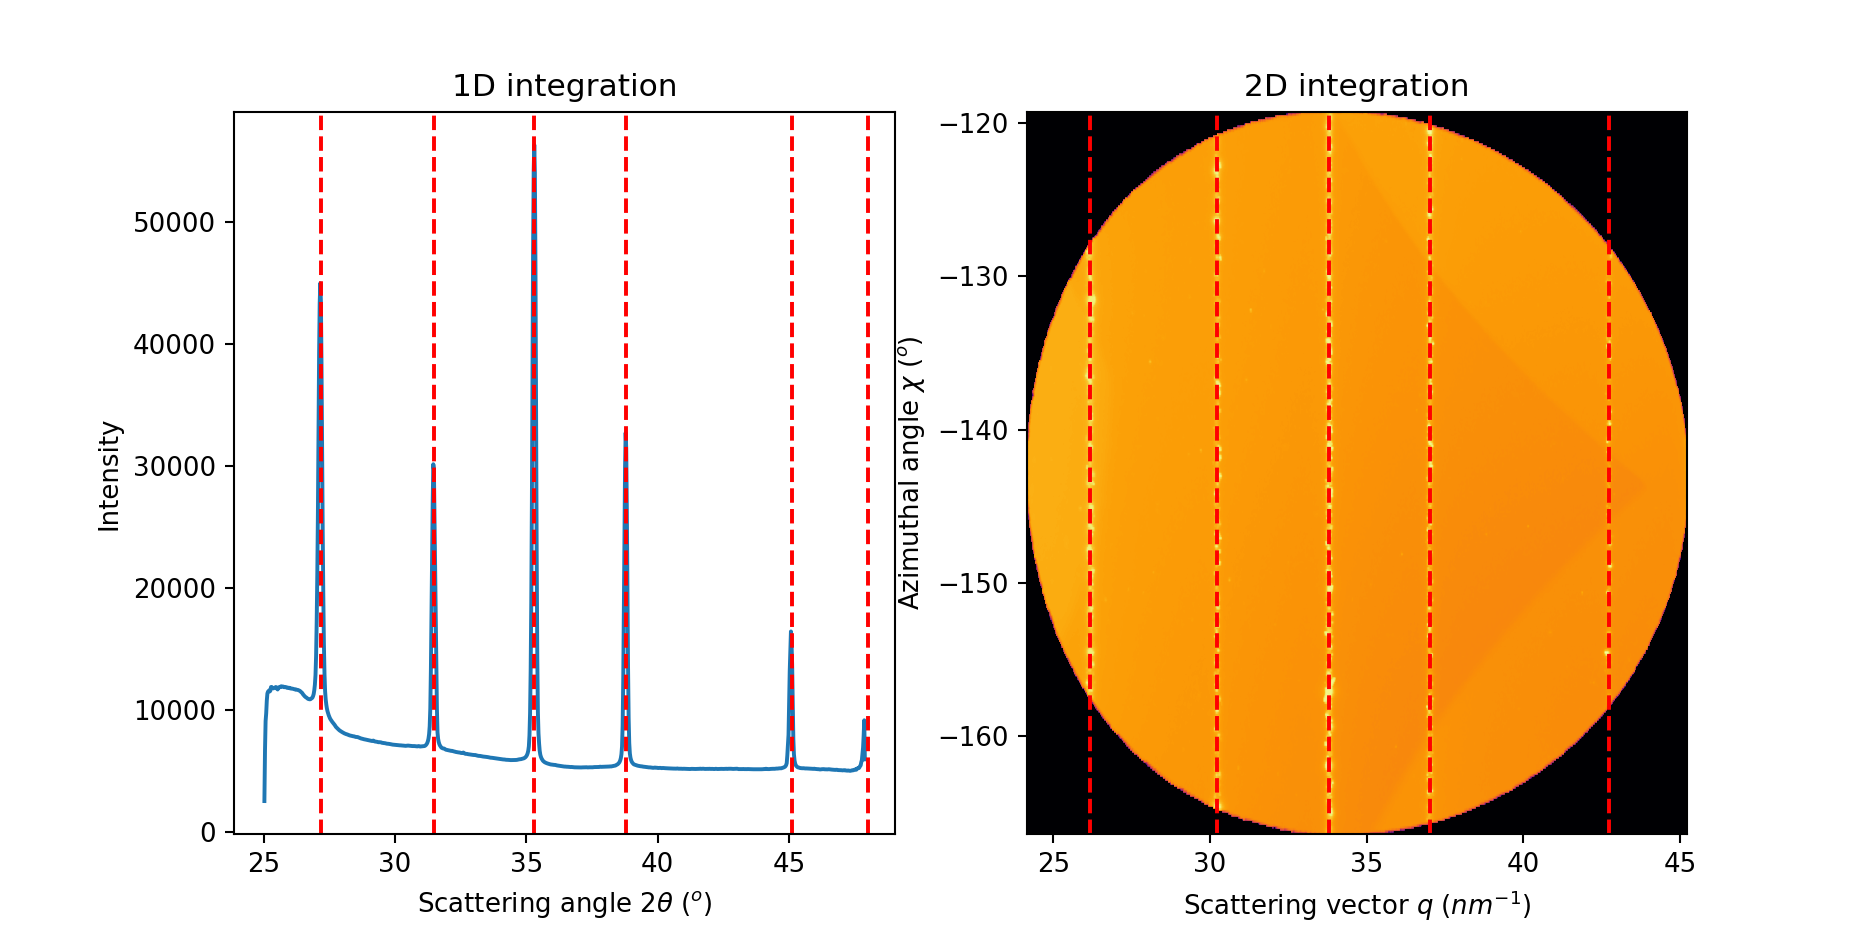

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
spectrum = azim_int.integrate1d(np.array(Image.fromarray(base_image.squeeze()).resize(detector_px)), 1000, 
                                unit="2th_deg", filename="integration.dat")
cake = azim_int.integrate2d(np.array(Image.fromarray(base_image.squeeze()).resize(detector_px)), 1000)
# Uncomment to use the processed image instead (not recommended)
# spectrum = azim_int.integrate1d(image, 1000, unit="2th_deg", filename="integration.dat")
# cake = azim_int.integrate2d(base_image, 1000)
pyFAI.gui.jupyter.plot1d(spectrum, calibrant=LaB6, ax=ax[0])
pyFAI.gui.jupyter.plot2d(cake, calibrant=LaB6, ax=ax[1])
_ = ax[1].set_title("2D integration")

In [ ]:
gr.save("lab6_250mm_2.poni")

### Miscellaneous

In [ ]:
plt.plot(spectrum[0], spectrum[1])
plt.show()